In [31]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from pathlib import Path
import pyvista as pv
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob

In [32]:
DATASET_NAME = 'RF_FULGUR_DT'
DATA_PATH = Path('./OUTPUT') / DATASET_NAME
PCA_RESULTS = DATA_PATH / 'PCA_results'
PARTICLES = DATA_PATH / f'{DATASET_NAME}_default_particles'


In [33]:
def load_shapes(directory):

    shapes = []  
    for filename in os.listdir(directory):
        if filename.endswith('.particles'):  
            filepath = os.path.join(directory, filename)
            shape = np.loadtxt(filepath)
            shapes.append(shape)
    return shapes

def load_eigenvectors(directory):
    eigenvectors = []
    files = sorted(os.listdir(directory))
    for filename in files:
        if filename.endswith('.eig'):
            filepath = os.path.join(directory, filename)
            eigenvector = np.loadtxt(filepath)
            eigenvectors.append(eigenvector)
    return np.array(eigenvectors)

### 1. Compactness

Nombre de composantes nécessaires pour dépasser 95% de variance cumulative : 2
Variance cumulative des 2 premières composantes : [0.53086071 0.97010985]


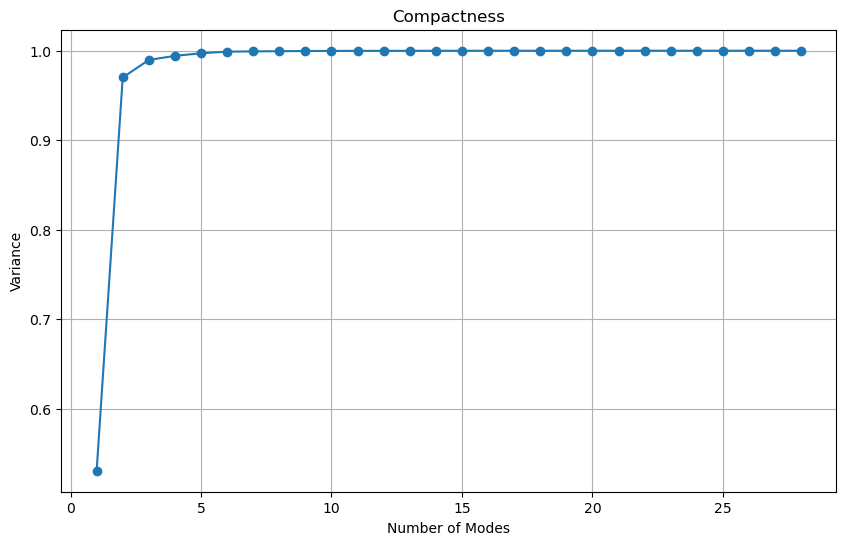

In [34]:
def compute_compactness(eigenvalues, threshold=0.95):
    total_variance = np.sum(eigenvalues)
    cumulative_variance = np.cumsum(eigenvalues) / total_variance
    num_components = np.argmax(cumulative_variance >= threshold) + 1
    return num_components, cumulative_variance

eigenvalues = np.loadtxt(PCA_RESULTS / 'eigenvalues.eval')
num_components, cumulative_variance = compute_compactness(eigenvalues)

print(f"Nombre de composantes nécessaires pour dépasser {int(100 * 0.95)}% de variance cumulative : {num_components}")
print(f"Variance cumulative des {num_components} premières composantes : {cumulative_variance[:num_components]}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Modes')
plt.ylabel('Variance')
plt.title('Compactness')
plt.grid(True)
plt.show()

### 2. Specificity Error

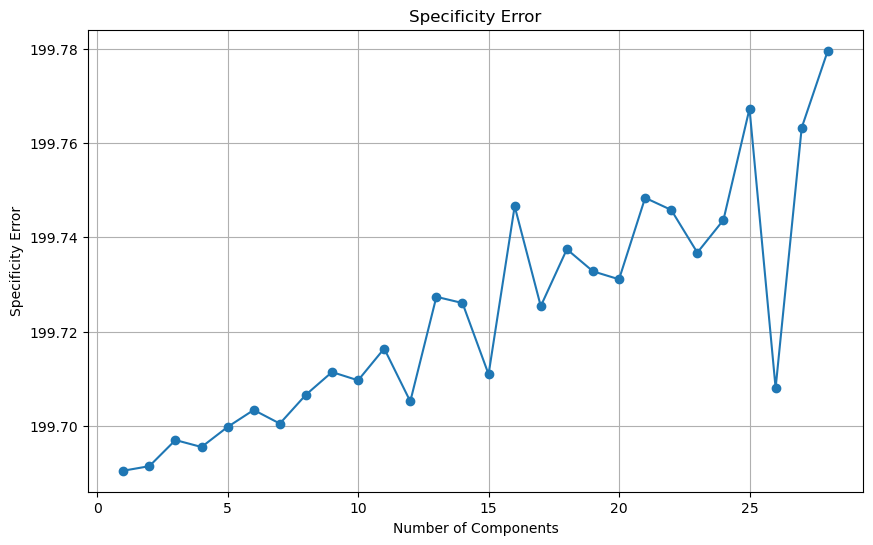

In [35]:
# Generation of synthetic shapes
def generate_synthetic_shapes(mean_shape, eigenvectors, num_components, num_samples):
    synthetic_shapes = []
    for _ in range(num_samples):
        coefficients = np.random.normal(0, 1, num_components)  # Coefficienti casuali
        synthetic_shape = mean_shape + np.sum([c * e for c, e in zip(coefficients, eigenvectors[:num_components])], axis=0)
        synthetic_shapes.append(synthetic_shape)
    return np.array(synthetic_shapes)

# Specificity Error
def specificity_error(real_shapes, eigenvectors, num_components, num_samples):
    total_error = 0

    # Leave-One-Out
    for i, shape in enumerate(real_shapes):
        leave_out_shapes = np.delete(real_shapes, i, axis=0)
        mean_shape_new = np.mean(leave_out_shapes, axis=0)  # New mean shape

        synthetic_shapes = generate_synthetic_shapes(mean_shape_new, eigenvectors, num_components, num_samples)

        # Minimum distance between synthetic and real shapes
        errors = []
        for synthetic in synthetic_shapes:
            distances = [np.linalg.norm(synthetic - real) for real in leave_out_shapes]
            errors.append(min(distances))
        
        total_error += np.mean(errors)

    mean_error = total_error / len(real_shapes)  # Mean error
    return mean_error

real_shapes = load_shapes(PARTICLES)
eigenvectors = load_eigenvectors(PCA_RESULTS)
eigenvectors = np.array([vec / np.linalg.norm(vec) for vec in eigenvectors])  # Normalizing eigenvectors

max_components = eigenvectors.shape[0]
num_samples = 100  # Number of synthetic shapes to generate

specificity_errors = []
for num in range(1, max_components + 1):
    error = specificity_error(real_shapes, eigenvectors, num, num_samples)
    specificity_errors.append(error)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), specificity_errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Specificity Error')
plt.title('Specificity Error')
plt.grid(True)
plt.show()

### 3. Generalization Error

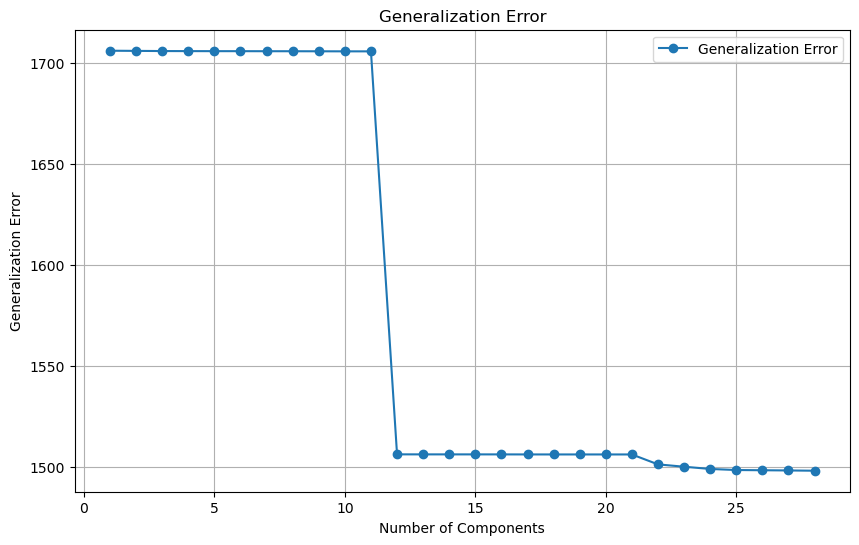

In [36]:
def calculate_generalization(real_shapes, eigenvectors, max_components):
    
    errors_by_components = []

    for num_components in range(1, max_components + 1):
        total_error = 0

        # "leave-one-out"
        for i, shape in enumerate(real_shapes):
            leave_out_shapes = np.delete(real_shapes, i, axis=0)

            # New mean shape
            mean_shape_new = np.mean(leave_out_shapes, axis=0)

            # Riconstruction of the shape
            delta_shape = shape - mean_shape_new
            reconstructed_shape = np.zeros_like(shape)
            for j in range(num_components):
                coefficient = np.dot(delta_shape.flatten(), eigenvectors[j].flatten())
                reconstructed_shape += coefficient * eigenvectors[j]

            # Error for the current shape
            error = np.linalg.norm(shape - reconstructed_shape)
            total_error += error

        mean_error = total_error / len(real_shapes)
        errors_by_components.append(mean_error)

    return errors_by_components

real_shapes = load_shapes(PARTICLES)
eigenvectors = load_eigenvectors(PCA_RESULTS)
eigenvectors = np.array([vec / np.linalg.norm(vec) for vec in eigenvectors])

# Global mean shape
mean_shape = np.mean(real_shapes, axis=0)

# Leave One Out Cross Validation
max_components = eigenvectors.shape[0]
generalization_errors = calculate_generalization(
    real_shapes, eigenvectors, max_components
)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), generalization_errors, marker='o', label="Generalization Error")
plt.xlabel('Number of Components')
plt.ylabel('Generalization Error')
plt.title('Generalization Error')
plt.grid(True)
plt.legend()
plt.show()